# Toy baseline model

Try to setup the baseline model following the example.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

## Settings

In [2]:
rdm_seed = 42
max_workers = 36

In [3]:
data_dir_local = Path('/home/yangzhe/data') / 'toy_model_data'
fe_dir = data_dir_local / 'fe'

features = [
    "funding_rate_expcumsum_0.5",
    "funding_rate_expcumsum_1",
    "funding_rate_expcumsum_2",
    "funding_rate_expcumsum_3",
    "funding_rate_expcumsum_5",
    "funding_rate_expcumsum_10",
]
target = "funding_rate_future_5"

# Trial

In [11]:
file_path = fe_dir / f"BTCUSDT.feather"
df_trial = pd.read_feather(file_path)
df_trial.dropna(inplace=True)

# get data before 2022-08-01
train_idx = (
    pd.to_datetime(df_trial["funding_timestamp"], unit="us").dt.strftime('%Y-%m-%d')
    < "2022-08-01"
)
df_train = df_trial[train_idx]
df_test = df_trial[~train_idx]
print(df_train.shape, df_test.shape)

x_train = df_train[features[0]].values
y_train = df_train[target].values

(453, 10) (97, 10)


In [12]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train.reshape(-1, 1), y_train)

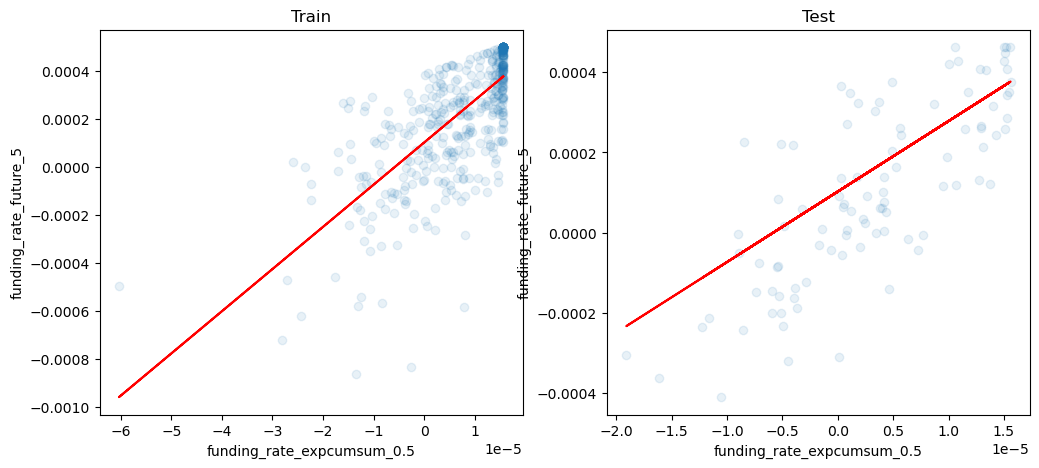

In [23]:
# Plot y vs x on df_train and df_test
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
x_train = df_train[features[0]].values
y_train = df_train[target].values
y_train_pred = model.predict(x_train.reshape(-1, 1))
ax[0].scatter(x_train, y_train, alpha=0.1)
ax[0].plot(x_train, y_train_pred, color='red')
ax[0].set_title('Train')
ax[0].set_xlabel(features[0])
ax[0].set_ylabel(target)

x_test = df_test[features[0]].values
y_test = df_test[target].values
y_test_pred = model.predict(x_test.reshape(-1, 1))
ax[1].scatter(x_test, y_test, alpha=0.1)
ax[1].plot(x_test, y_test_pred, color='red')
ax[1].set_title('Test')
ax[1].set_xlabel(features[0])
ax[1].set_ylabel(target)

plt.show()


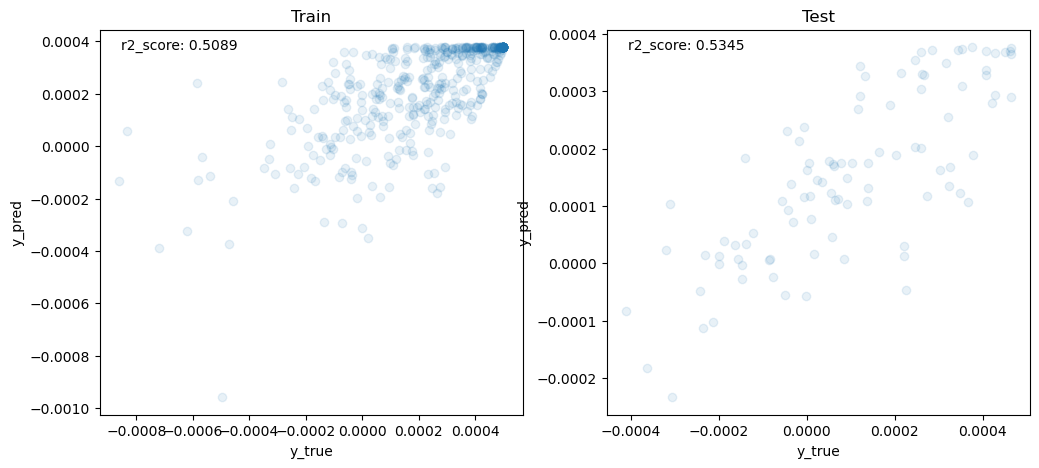

In [26]:
# plot y_pred vs y on df_train and df_test
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].scatter(y_train, y_train_pred, alpha=0.1)
ax[0].set_title('Train')
ax[0].set_xlabel('y_true')
ax[0].set_ylabel('y_pred')
cur_r2 = r2_score(y_train, y_train_pred)
ax[0].text(0.05, 0.95, f"r2_score: {cur_r2:.4f}", transform=ax[0].transAxes)

ax[1].scatter(y_test, y_test_pred, alpha=0.1)
ax[1].set_title('Test')
ax[1].set_xlabel('y_true')
ax[1].set_ylabel('y_pred')
cur_r2 = r2_score(y_test, y_test_pred)
ax[1].text(0.05, 0.95, f"r2_score: {cur_r2:.4f}", transform=ax[1].transAxes)

plt.show()

In [27]:
def get_pnl(x, funding, buythres, sellthres):

    obsNum = len(x)
    signal = np.zeros(obsNum)
    signal[x > buythres] = 1
    signal[x < sellthres] = -1
    position = np.zeros(obsNum)
    fee = np.zeros(obsNum)
    toBuy = False
    toSell = False
    for ii in range(obsNum):

        if ii >= 1:
            position[ii] = position[ii - 1]
        if toBuy:
            position[ii] = 1
            fee[ii] = feeRate
        if toSell:
            position[ii] = 0
            fee[ii] = feeRate

        toBuy = False
        toSell = False
        if signal[ii] == 1 and position[ii] == 0:
            toBuy = True
        if signal[ii] == -1 and position[ii] == 1:
            toSell = True
    pnl = np.sum(position * funding) - np.sum(fee)
    return pnl

In [31]:
# scan buythres and sellthres
range_max = max(max(y_train_pred), max(y_test_pred))
buythres_list = np.linspace(-range_max, range_max * 0.9, 100)
sellthres_list = np.linspace(-range_max, range_max * 0.9, 100)

pnl_list_train = [[0] * 100 for _ in range(100)]
fr_train = df_train["funding_rate"].values
pnl_list_test = [[0] * 100 for _ in range(100)]
fr_test = df_test["funding_rate"].values

for i, buythre in enumerate(buythres_list):
    for j, sellthre in enumerate(sellthres_list):
        pnl_list_train[i][j] = get_pnl(y_train, fr_train, buythre, sellthre)
        pnl_list_test[i][j] = get_pnl(y_test, fr_test, buythre, sellthre)


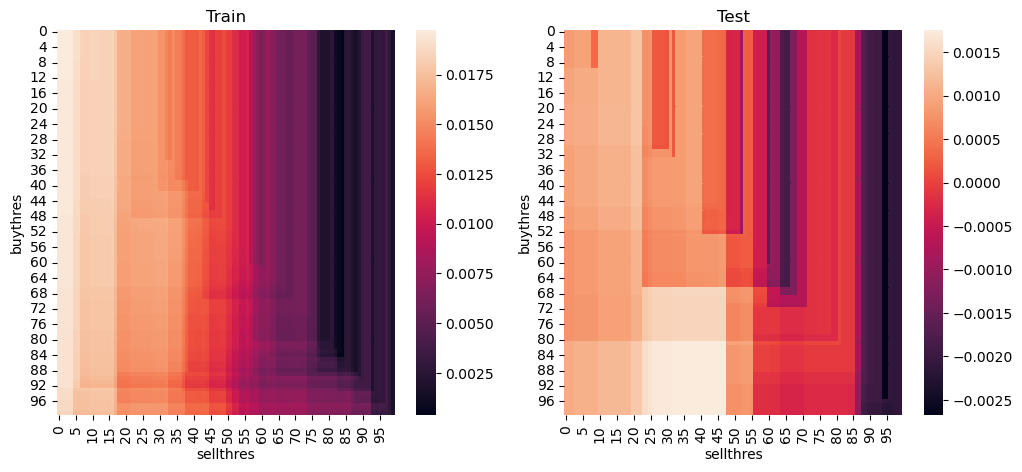

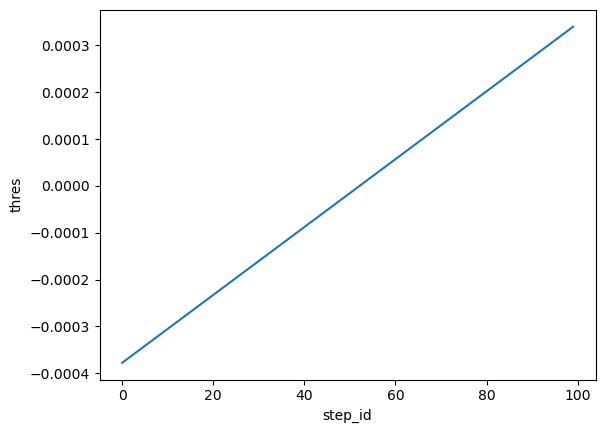

In [33]:
# plot heat map on df_train and df_test
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.heatmap(pnl_list_train, ax=ax[0])
ax[0].set_title('Train')
ax[0].set_xlabel('sellthres')
ax[0].set_ylabel('buythres')
sns.heatmap(pnl_list_test, ax=ax[1])
ax[1].set_title('Test')
ax[1].set_xlabel('sellthres')
ax[1].set_ylabel('buythres')
plt.show()

step_id = range(100)
# plot buythres_list vs step_id
fig, ax = plt.subplots()
ax.plot(step_id, buythres_list)
ax.set_xlabel("step_id")
ax.set_ylabel("thres")
plt.show()